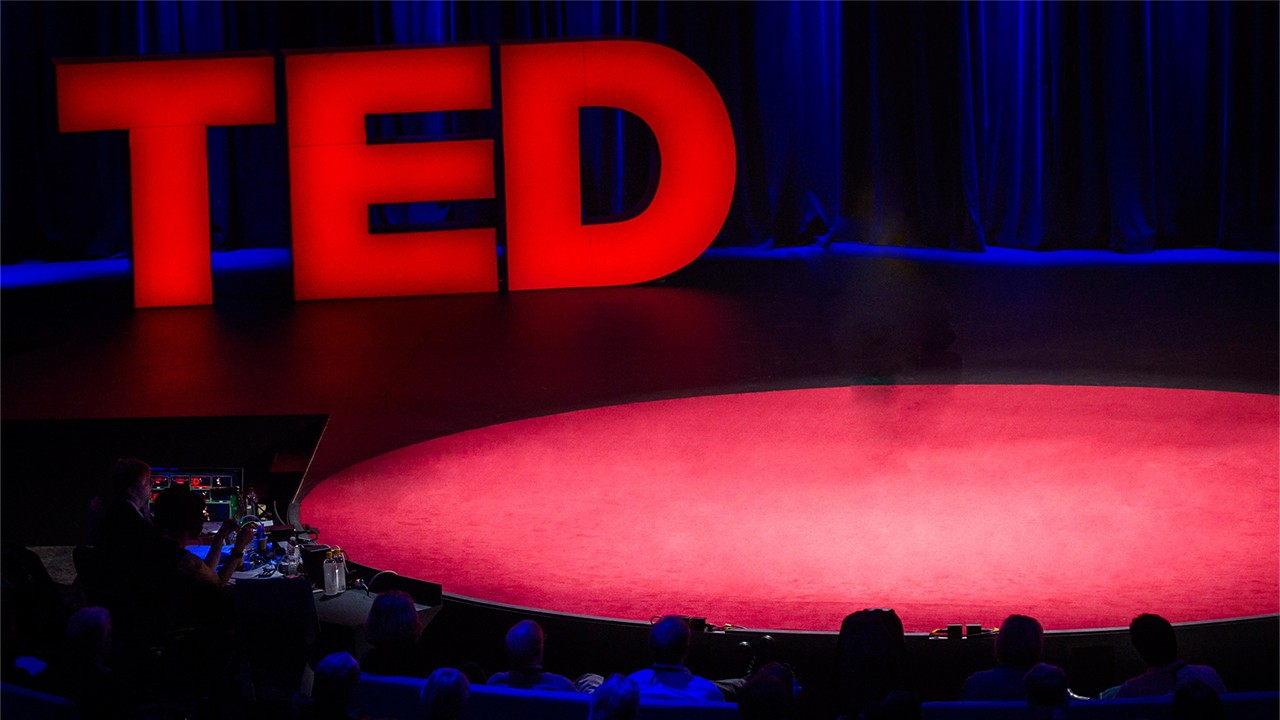

In [1]:
import pandas as pd
import numpy as np
import nltk
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
import scipy
from scipy import spatial
import re
from textblob import TextBlob, Word
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
sw = stopwords.words('english')
st = PorterStemmer()

# DATA CLEANING AND PREPROCESSING

In [2]:
df1= pd.read_csv('ted_main.csv')
df2 = pd.read_csv('transcripts.csv')

In [3]:
ted_df = pd.merge(df1,df2,on='url')
ted_df = ted_df[['title','transcript']]
ted_df.head()

,title,transcript
0,Do schools kill creativity?,Good morning. How are you?(Laughter)It's been ...
1,Averting the climate crisis,"Thank you so much, Chris. And it's truly a gre..."
2,Simplicity sells,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,Greening the ghetto,If you're here today — and I'm very happy that...
4,The best stats you've ever seen,"About 10 years ago, I took on the task to teac..."


In [4]:
ted_df.shape

(2467, 2)

In [5]:
def text_preprocessing(df):
    
    """=== Lower Case ==="""
    df['transcript'] = df['transcript'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    print("==== Lower Case Done ====")
    
    """=== Removal Of Stopwords ==="""
    df['transcript'] = df['transcript'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
    
    print("==== Stopwords Removed ====")
    
    # """=== Spelling Correction ==="""
    #df['transcript'] = df['transcript'].apply(lambda x: str(TextBlob(x).correct()))

     # print("==== Spelling Correction Done ====")
    
    """=== Removal Of Punctuation ==="""
    df['transcript'] = df['transcript'].str.replace('[^\w\s]','')
    
    print("==== Removal Of Punctuation Done ====")
    
    """=== Removal Of Numerical ==="""
    df['transcript'] = df['transcript'].str.replace('[0-9]','')
    
    print("==== Removal Of Numerical Done ====")
    
    return df

<>:19: SyntaxWarning: invalid escape sequence '\w'
<>:19: SyntaxWarning: invalid escape sequence '\w'
C:\Users\pj900\AppData\Local\Temp\ipykernel_12052\255912014.py:19: SyntaxWarning: invalid escape sequence '\w'
  df['transcript'] = df['transcript'].str.replace('[^\w\s]','')


In [6]:
ted_df = text_preprocessing(ted_df)
ted_df.head()

==== Lower Case Done ====
==== Stopwords Removed ====
==== Removal Of Punctuation Done ====
==== Removal Of Numerical Done ====


,title,transcript
0,Do schools kill creativity?,"good morning. you?(laughter)it's great, it? i'..."
1,Averting the climate crisis,"thank much, chris. truly great honor opportuni..."
2,Simplicity sells,"(music: ""the sound silence,"" simon & garfunkel..."
3,Greening the ghetto,today — i'm happy — heard sustainable developm...
4,The best stats you've ever seen,"10 years ago, took task teach global developme..."


In [7]:
ted_df['transcript'] = ted_df['transcript'].apply(lambda x:" ".join([st.stem(x) for x in x.split()]))

# FEATURE ENGINEERING

In [8]:
cv =CountVectorizer()
cv.fit(ted_df['transcript'])
cv_tedfeatures = cv.transform(ted_df['transcript'])

In [9]:
#word level TF-IDF
tv = TfidfVectorizer()
tv.fit(ted_df['transcript'])
tv_tedfeatures = tv.transform(ted_df['transcript'])

In [10]:
#Load
m1=gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
def get_embedding(x, out=False):
    if x in m1.key_to_index:  
        if out == True:
            return m1.get_vector(x)
        return m1[x]  
    else:
        return np.zeros(m1.vector_size)

In [12]:
op = {}
for i in ted_df['transcript']:
    avg_vct_doc = (np.mean(np.array([get_embedding(a) for a in nltk.word_tokenize((i))]),axis=0))
    d = {i:(avg_vct_doc)}
    op.update(d)

# Model Building Phase

In [13]:
results_key = list()
results_value = list()
for key, value in op.items():
 results_key.append(key)
 results_value.append(np.array(value))

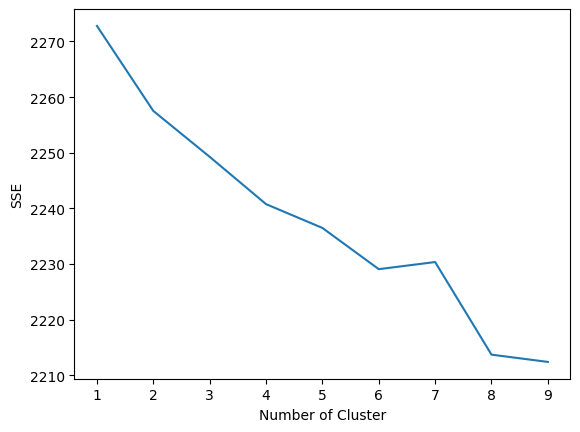

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

elbow_method = {}
for k in range(1,10):
    kmeans_elbow = KMeans(n_clusters=k).fit(tv_tedfeatures)
    elbow_method[k] = kmeans_elbow.inertia_

plt.figure()
plt.plot(list(elbow_method.keys()),list(elbow_method.values()))
plt.xlabel("Number of Cluster")
plt.ylabel("SSE")
plt.show()

In [15]:
from sklearn.metrics import silhouette_score

for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters).fit(cv_tedfeatures)
    label = kmeans.labels_
    
    sil_coeff = silhouette_score(cv_tedfeatures,label,metric='euclidean')
    
    print("For n_clusters={},The Silhouette Coefficient is {}".format(n_clusters,sil_coeff))

For n_clusters=2,The Silhouette Coefficient is 0.137579074849859
For n_clusters=3,The Silhouette Coefficient is 0.07250476459217255
For n_clusters=4,The Silhouette Coefficient is 0.07985250750016913
For n_clusters=5,The Silhouette Coefficient is 0.03293665335931681
For n_clusters=6,The Silhouette Coefficient is 0.019287657207689574
For n_clusters=7,The Silhouette Coefficient is 0.01911592687058818
For n_clusters=8,The Silhouette Coefficient is 0.03064968289379274
For n_clusters=9,The Silhouette Coefficient is -0.004423524007899663


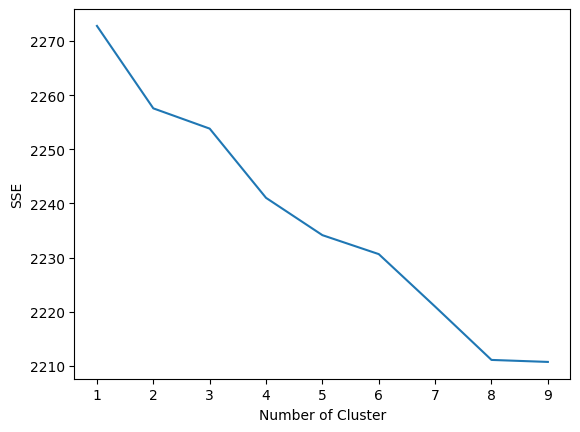

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

elbow_method = {}
for k in range(1,10):
    kmeans_elbow = KMeans(n_clusters=k).fit(tv_tedfeatures)
    elbow_method[k] = kmeans_elbow.inertia_

plt.figure()
plt.plot(list(elbow_method.keys()),list(elbow_method.values()))
plt.xlabel("Number of Cluster")
plt.ylabel("SSE")
plt.show()

In [17]:
from sklearn.metrics import silhouette_score

for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters=n_clusters).fit(tv_tedfeatures)
    label = kmeans.labels_
    
    sil_coeff = silhouette_score(cv_tedfeatures,label,metric='euclidean')
    
    print("For n_clusters={},The Silhouette Coefficient is {}".format(n_clusters,sil_coeff))

For n_clusters=2,The Silhouette Coefficient is 0.021311198982255534
For n_clusters=3,The Silhouette Coefficient is -0.08793863204884184
For n_clusters=4,The Silhouette Coefficient is -0.03391123921304437
For n_clusters=5,The Silhouette Coefficient is -0.0427881367522781
For n_clusters=6,The Silhouette Coefficient is -0.01294466261434748
For n_clusters=7,The Silhouette Coefficient is -0.08252134949675527
For n_clusters=8,The Silhouette Coefficient is -0.13411353451247762
For n_clusters=9,The Silhouette Coefficient is -0.08198568182417094


In [18]:
segments = KMeans(n_clusters=2)
segments.fit(results_value)

output = segments.labels_.tolist()

ted_segmentation = {'transcript':results_key,'cluster':output}
output_df = pd.DataFrame(ted_segmentation)

output_df['cluster'] = segments.labels_.tolist()

output_df

,transcript,cluster
0,"good morning. you?(laughter)it' great, it? i'v...",0
1,"thank much, chris. truli great honor opportun ...",0
2,"(music: ""the sound silence,"" simon & garfunkel...",0
3,today — i'm happi — heard sustain develop save...,1
4,"10 year ago, took task teach global develop sw...",1
...,...,...
2459,"so, tri explain someth grandma grew up, pay at...",0
2460,pictur sunset mar taken nasa' curios rover 201...,1
2461,"earli day graduat student, went snorkel trip c...",1
2462,took cell phone accident made famous.(laughter...,0


# Cluster Visualization

In [19]:
cluster_1 = output_df[output_df.cluster == 1]
cluster_0 = output_df[output_df.cluster == 0]

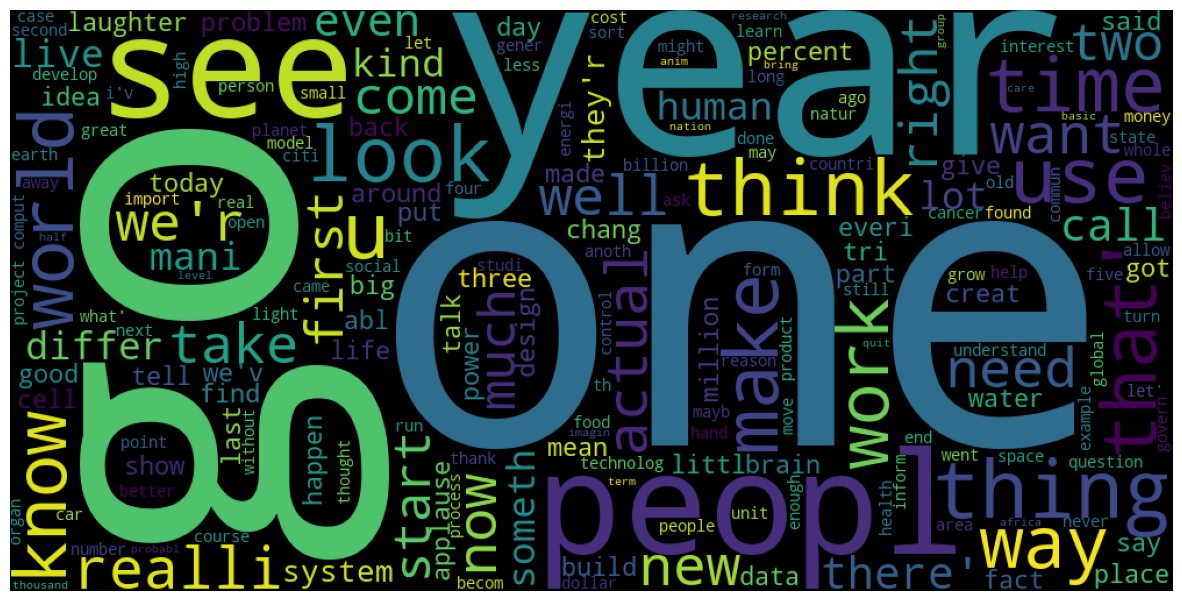

In [20]:
from wordcloud import WordCloud,STOPWORDS

wordcloud = WordCloud(width=1000,height=500,collocations=False).generate_from_text(' '.join(cluster_1['transcript']))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


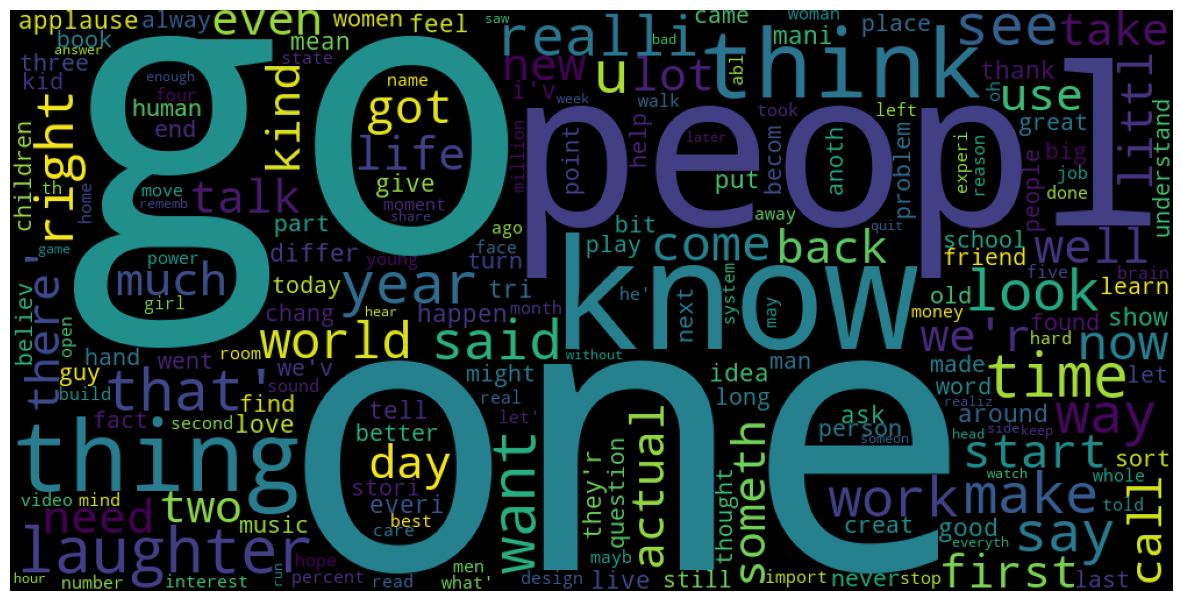

In [21]:
from wordcloud import WordCloud,STOPWORDS

wordcloud = WordCloud(width=1000,height=500,collocations=False).generate_from_text(' '.join(cluster_0['transcript']))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [22]:
def process(doc):
    toks = [w for s in nltk.sent_tokenize(doc) for w in nltk.word_tokenize(s)]
    filt_toks = []
    for i in toks:
        if re.search('[a-zA-Z]',i):
            filt_toks.append(i)
    post_process = [st.stem(t) for t in filt_toks]
    
    return post_process

In [23]:
process("good morning. you?(laughter)it' great, it? i'v")

['good', 'morn', 'you', 'laughter', 'it', 'great', 'it', 'i', 'v']

In [24]:
cluster_1.transcript

3       today — i'm happi — heard sustain develop save...
4       10 year ago, took task teach global develop sw...
7       i'm go present three project rapid fire. much ...
10      i'm go take journey quickly. explain wish, i'm...
12      i'm luckiest guy world. got see last case kill...
                              ...                        
2457    today i'm here, actually, pose question. life?...
2458    stand africa' current prostrat condit futur pr...
2460    pictur sunset mar taken nasa' curios rover 201...
2461    earli day graduat student, went snorkel trip c...
2463    human becom urban species, cities, natur habit...
Name: transcript, Length: 1175, dtype: object

In [25]:
from gensim import corpora,models,similarities

toks = [process(a) for a in cluster_1.transcript]

talks = [[x for x in y if x not in sw] for y in toks]

dictonary = corpora.Dictionary(talks)

In [26]:
doc = [dictonary.doc2bow(text) for text in talks]

tm = models.LdaModel(doc,num_topics=5,id2word=dictonary)

In [27]:
tm.show_topics()

[(0,
  '0.009*"go" + 0.009*"like" + 0.007*"one" + 0.007*"r" + 0.006*"peopl" + 0.006*"actual" + 0.006*"make" + 0.006*"look" + 0.005*"think" + 0.005*"know"'),
 (1,
  '0.008*"go" + 0.007*"see" + 0.007*"peopl" + 0.007*"one" + 0.007*"like" + 0.006*"r" + 0.006*"thing" + 0.005*"use" + 0.005*"get" + 0.005*"way"'),
 (2,
  '0.009*"one" + 0.007*"go" + 0.006*"think" + 0.006*"r" + 0.006*"year" + 0.006*"see" + 0.006*"time" + 0.006*"peopl" + 0.006*"get" + 0.005*"work"'),
 (3,
  '0.008*"like" + 0.007*"go" + 0.007*"one" + 0.006*"peopl" + 0.006*"get" + 0.006*"use" + 0.005*"thing" + 0.005*"year" + 0.005*"realli" + 0.005*"actual"'),
 (4,
  '0.008*"one" + 0.008*"like" + 0.007*"peopl" + 0.006*"year" + 0.006*"go" + 0.005*"world" + 0.005*"r" + 0.005*"would" + 0.005*"thing" + 0.005*"use"')]

In [28]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(tm,doc,dictonary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.001262  0.001129       1        1  25.505449
4      0.002676 -0.003385       2        1  24.421901
2      0.004041  0.000737       3        1  18.872525
3     -0.002794  0.005239       4        1  16.718453
0     -0.005186 -0.003720       5        1  14.481673, topic_info=       Term         Freq        Total Category  logprob  loglift
306      go  8369.000000  8369.000000  Default  30.0000  30.0000
436    like  8363.000000  8363.000000  Default  29.0000  29.0000
13   actual  4841.000000  4841.000000  Default  28.0000  28.0000
762   think  5709.000000  5709.000000  Default  27.0000  27.0000
409    know  4650.000000  4650.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
814     use   695.662277  5691.518290   Topic5  -5.4971  -0.1696
28     also   498.806523  3590.846579   Topic5  -5.8297  -0.0416
853    work   551.750193  4669.604078   Topic5  -5.7288  -0.2034
816       v   523.755160  4093.483349   Topic5  -5.7809  -0.1238
832    want   512.051371  4079.043038   Topic5  -5.8035  -0.1429

[466 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
3          1  0.252745      'm
3          2  0.210790      'm
3          3  0.176279      'm
3          4  0.199625      'm
3          5  0.160715      'm
...      ...       ...     ...
10761      1  0.452003  zipcar
10761      2  0.169501  zipcar
10761      3  0.113001  zipcar
10761      4  0.113001  zipcar
10761      5  0.113001  zipcar

[1219 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

In [35]:
# dictionary
dictionary1 = corpora.Dictionary(talks)
# bow
doc1 = [dictionary1.doc2bow(text) for text in talks]
tm2 = models.LdaModel(doc1, num_topics=6,id2word=dictonary)
tm2.show_topics()

[(0,
  '0.009*"go" + 0.009*"like" + 0.008*"peopl" + 0.007*"one" + 0.007*"time" + 0.007*"know" + 0.007*"laughter" + 0.007*"thing" + 0.006*"\'m" + 0.005*"make"'),
 (1,
  '0.010*"peopl" + 0.010*"one" + 0.009*"like" + 0.008*"go" + 0.007*"look" + 0.007*"realli" + 0.006*"get" + 0.006*"know" + 0.006*"laughter" + 0.005*"us"'),
 (2,
  '0.011*"go" + 0.010*"think" + 0.010*"like" + 0.009*"peopl" + 0.008*"know" + 0.007*"one" + 0.007*"thing" + 0.007*"say" + 0.006*"get" + 0.006*"would"'),
 (3,
  '0.009*"go" + 0.009*"one" + 0.008*"like" + 0.008*"know" + 0.008*"peopl" + 0.007*"would" + 0.007*"thing" + 0.007*"laughter" + 0.006*"get" + 0.006*"said"'),
 (4,
  '0.010*"go" + 0.009*"one" + 0.008*"like" + 0.007*"peopl" + 0.007*"get" + 0.007*"want" + 0.007*"time" + 0.007*"think" + 0.006*"thing" + 0.006*"know"'),
 (5,
  '0.013*"peopl" + 0.009*"one" + 0.008*"go" + 0.008*"like" + 0.008*"thing" + 0.008*"r" + 0.007*"know" + 0.006*"\'m" + 0.006*"get" + 0.006*"want"')]

In [36]:
pyLDAvis.gensim.prepare(tm2, doc1, dictionary1)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.004528 -0.000050       1        1  26.490959
2      0.004507  0.002097       2        1  25.881545
5     -0.000134 -0.004678       3        1  16.901767
0     -0.000228  0.000054       4        1  13.148373
3     -0.004185  0.005717       5        1  11.656742
1     -0.004487 -0.003140       6        1   5.920613, topic_info=       Term          Freq         Total Category  logprob  loglift
404   peopl  10971.000000  10971.000000  Default  30.0000  30.0000
383     one  10472.000000  10472.000000  Default  29.0000  29.0000
306    like  10718.000000  10718.000000  Default  28.0000  28.0000
451  realli   5638.000000   5638.000000  Default  27.0000  27.0000
315    look   5634.000000   5634.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
520   start    236.956271   3963.977305   Topic6  -5.7249   0.0096
570    time    304.257821   6403.174955   Topic6  -5.4749  -0.2199
596       v    250.254313   4428.406838   Topic6  -5.6703  -0.0466
562   thing    333.540569   8219.604042   Topic6  -5.3830  -0.3778
628    work    246.712883   5299.149290   Topic6  -5.6845  -0.2403

[546 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
3          1  0.263749           'm
3          2  0.255765           'm
3          3  0.187106           'm
3          4  0.142398           'm
3          5  0.099287           'm
...      ...       ...          ...
36733      5  0.187745          ♪sc
36734      1  0.368713     ♪speaker
36734      4  0.368713     ♪speaker
19902      4  0.565388  ♫instrument
8826       5  0.595958        ♫what

[1517 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 6, 1, 4, 2])